In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 6)
pd.set_option("plotting.backend", "matplotlib")
%matplotlib inline

plt.style.use('default')

# Методы

## Методы генерации

In [21]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    """Генерация произвольной зависимости
    Входные переменные:
    ===========
    x: массив данных из которых будет генерироваться зависимость
    a: коэффициент на который входные данные будут умножаться
    если а - список, то это коэффициенты в полиномиальной зависимости
    так, а = [1,2,3] позволит сгенерировать зависимость вида 1*x+ 2*x^2 +3*x^3
    b: коэффициент который будет добавлен к данным (постоянная прибавочка)
    f: функция которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки
    """
    x = np.atleast_1d(x)[:]  # убеждаемся что данные - одномерный массив
    a = np.atleast_1d(a)

    if f is None:
        fx = 0
    else:
        f = np.atleast_1d(f)
        fx = np.sum([fi(x) for fi in f], axis=0)

    ax = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return fx + ax + b

def noises(shape, noise_power):
    """Генерация случайного шума
    Входные переменные:
    ===========
    shape: размерность массива данных
    noise_power: коэффициент ~ сила шума
    """
    return np.random.randn(*shape) * noise_power  # библиотека numpy может генерировать случайные числа.
    # в данном случае - нормальное распределение (среднее = 0, стандартное отклонение = 1 )

def dataset(a, b, f=None, x_count=250, x_max=1, noise_power=0, random_x=True, seed=42):
    """Генерация набора данных
    Входные переменные:
    ===========
    a: коэффициент на который входные данные будут умножаться
    если а - список, то это коэффициенты в полиномиальной зависимости
    так, а = [1,2,3] позволит сгенерировать зависимость вида 1*x+ 2*x^2 +3*x^3
    b: коэффициент который будет добавлен к данным (постоянная прибавочка)
    f: функция которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки
    x_count: количество точек данных
    x_max: максимальное значение данных
    noise_power: коэффициент ~ сила шума
    random_x: как будут распределены данные (линейно, или случайно)
    seed: фиксированный сид случайных чисел (для повторяемости)
    """

    np.random.seed(seed)  # фиксируем случайный seed

    if random_x:  # если мы хотим случайно распределить данные
        x = np.sort(np.random.rand(x_count)) * x_max  # то x будет N случайных числе из диапазона от 0 до x_max
    else:  # иначе
        x = np.linspace(0, x_max, x_count)  # х это равномерно распределенные N чисел из диапазона от 0 до x_max

    y_true =  true_fun(x, a, b, f)  # создаем пустой массив который будет "наполнять" зависимостями

    # for f_ in np.append([], f):  # если f - задана списком, то мы учтем все варианты
    #     y_true = np.append(y_true, true_fun(x, a, b, f_))  # применяем описанную выше функцию true_fun

    y_true = y_true.reshape(-1, x_count).T
    y = y_true + noises(y_true.shape, noise_power)  # добавляем шум

    return y, y_true, np.atleast_2d(
        x).T  # возвращаем зашумленные значения зависимостей, зависимости без шума, и массив входных данных

## Методы визуализации

In [22]:

def vis_data(y, y_true, x, title):
    """Визуализация полученного набора данных
    Входные переменные:
    ===========
    y: зашумленные значения зависимостей
    y_true: зависимости без шума
    x: массив входных данных
    title: общий заголовок
    """
    fig = plt.figure(figsize=(15, 10))  # создаем "полотно", на котором будем "рисовать" график
    # рисуем с помощью библиотеки matplotlib
    plt.scatter(x[:, 0],  # какую переменную используем для горизонтальной оси - массив данных х
                y,  # какую переменную используем для вертикальной оси - зашумленные значения зависимостей
                edgecolor='b',  # цвет маркера
                label="Зашумленные Данные",  # название зависимости, которое будет отображено в легенде
                s=196,  # квадрат радиуса
                alpha=0.6)  # прозрачность
    plt.scatter(x[:, 0], y_true, label="Реальные Данные", s=81, c='g',
                alpha=0.8)  # аналогично вышеописанному, только для зависимости без шума
    # и с другими параметрами маркеров (цвет, размер, прозрачность, название)
    plt.grid()  # чтобы была сетка
    plt.xlabel('x', fontsize=15)  # название горизонтальной оси
    plt.ylabel('y', fontsize=15)  # название вертикальной оси
    plt.legend(fontsize=15)  # чтобы была легенда
    plt.title(title, fontsize=18)  # заголовок
    plt.xticks(fontsize=15)  # чтобы промежуточные значения горизонтальной оси были не маленькими
    plt.yticks(fontsize=15);  # чтобы промежуточные значения вертикальной оси были не маленькими
    plt.tight_layout()  # чтобы полотно было без пустого пространство
    plt.show()

## Класс линейной регрессии

In [23]:
class LinearRegression():
    def __init__(self,
                 learning_rate=0.5,
                 epochs=100,
                 weights=None,
                 bias=None,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = weights
        self.bias = bias
        self.seed = random_state
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.cost = np.zeros(epochs)

        # если веса и смещения заданы, совмещаем в один массив, если мы этого не сделали
        if not (self.weights is None) and self.bias and self.weights[0] != self.bias:
            self.weights = np.append(self.bias, self.weights)

    def forward(self, X):
        return np.dot(X, self.weights)

    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size

    def grad_step(self, yhat, y, X):
        return 2 * np.dot(X.T, (yhat - y)) / y.size

    def update(self):
        return self.weights - self.lr * self.grad

    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)

    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    def score(self, X, y):
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))

    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])

        if self.bias is None:
            self.bias = self.init(1)

        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)

        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size

        for i in range(self.epochs):
            loss = 0
            for cnt, (x_batch, y_batch) in enumerate(self.load_batch(X, y)):

                yhat = self.forward(x_batch)
                self.grad = self.grad_step(yhat, y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat, y_batch)

                if cnt >= self.n_batches:
                    break
            self.cost[i] = loss / self.n_batches

        self.bias = self.weights[0]


    def load_batch(self, X, y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch = np.take(X, idx_batch, axis=0)
            x_batch = self.add_bias(x_batch)
            y_batch = np.take(y, idx_batch)
            yield x_batch, y_batch

    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=24)
        plt.ylabel('Функция Потерь', fontsize=24)
        plt.title(title, fontsize=24)
        plt.show()

    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

    def vis_weigths(self):
        #np.hstack([b,w])
        numbers = np.arange(0, len(self.weights))
        tick_labels = ['w' + str(num) for num in numbers]
        cc = [''] * len(numbers)
        for n, val in enumerate(self.weights):
            if val < 0:
                cc[n] = 'red'
            elif val >= 0:
                cc[n] = 'blue'

        plt.bar(x=numbers, height=self.weights, color=cc)
        plt.xticks(np.arange(0, len(self.weights)), tick_labels)
        plt.show()

    def plot_model_class(self, x_train, y_train, x_test, x, y, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(x_train[:, 0], self.predict(x_train),
                 '.', label='Предсказание на x_train',
                 markersize=15)
        plt.plot(x_test[:, 0], self.predict(x_test),
                 'o', label='Предсказание на x_test',
                 markersize=15, alpha=0.8)
        plt.plot(x_train[:, 0], y_train, '.',
                 label="Тренировочные данные", linewidth=2, c='r')
        plt.plot(x[:, 0], y, '--',
                 label="Истинные Значения", linewidth=4, c='g')
        plt.legend(fontsize=20);
        plt.grid()
        plt.xlabel('x', fontsize=35)
        plt.ylabel('y', fontsize=35);
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.title(title, fontsize=24)
        plt.show()

    @staticmethod
    def to_polynom(x, order=1, add_bias=False):
        order_range = range(0 if add_bias else 1, order + 1, 1)
        x = np.atleast_1d(x)[:]
        out = np.array([])
        for i in order_range:
            out = np.append(out, np.power(x, i))
        return out.reshape(-1, x.size).T


    def train_test_split(self, x, y, train_size=None, test_size=None,  shuffle=True):
        np.random.seed(self.seed)

        size = y.shape[0]
        idxs = np.arange(size)
        if shuffle: np.random.shuffle(idxs)

        if test_size and train_size is None:
            if (test_size <= 1):
                train_size = 1 - test_size
            else:
                train_size = size - test_size
            test_size = None

        if train_size is None or train_size > size: train_size = size

        if (train_size <= 1): train_size *= size

        if test_size is not None:
            if test_size <= 1: test_size *= size
            if test_size > size: test_size = size - train_size
        else:
            test_size = 0

        x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
        x_val, y_val = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

        if test_size > 0:
            x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
            return x_train, x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze()
        return x_train, x_val, y_train.squeeze(), y_val.squeeze()

## Класс линейной регрессии c регуляризацией L1

In [24]:
class LassoRegression(LinearRegression):
    def __init__(self,
                 learning_rate=0.5,
                 l1_penalty=0.001,
                 epochs=100,
                 weights=None,
                 bias=None,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42):
        super().__init__(learning_rate=learning_rate,
                         epochs=epochs,
                         weights=weights,
                         bias=bias,
                         batch_size=batch_size,
                         n_batches=n_batches,
                         random_state=random_state)
        self.l1_penalty = l1_penalty

    def loss(self, yhat, y):
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    def update(self):
        return self.weights - self.lr * (self.grad + np.sign(self.weights) * self.l1_penalty)

## Класс линейной регрессии  c регуляризацией L2

In [25]:
class RidgeRegression(LinearRegression):
    def __init__(self,
                 learning_rate=0.5,
                 l2_penalty=0.001,
                 epochs=100,
                 weights=None,
                 bias=None,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42):
        super().__init__(learning_rate=learning_rate,
                         epochs=epochs,
                         weights=weights,
                         bias=bias,
                         batch_size=batch_size,
                         n_batches=n_batches,
                         random_state=random_state)
        self.l2_penalty = l2_penalty

    def loss(self, yhat, y):
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    def update(self):
        l2_term = self.l2_penalty * np.mean(self.weights[1:])
        return self.weights - self.lr * (self.grad + l2_term)

## Классы для нормализации и стандартизации

In [26]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

# Генерация зависимостей

## Генерация почти линейной зависимости

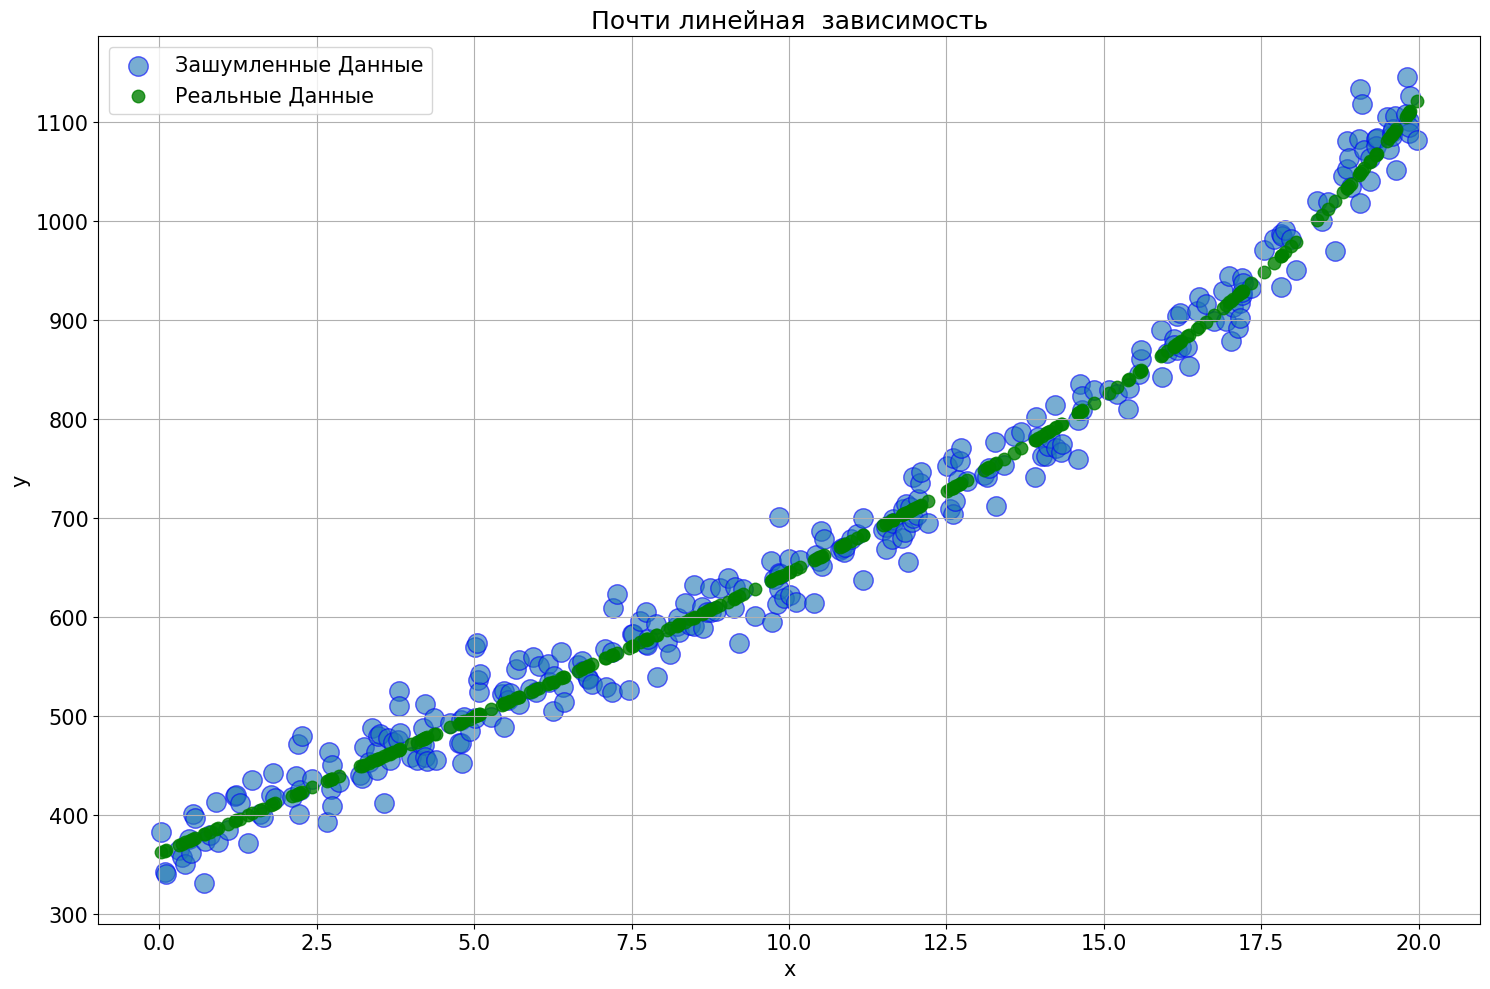

In [27]:
y1, y1_true, x1 = dataset(a = [27],
                       b = 360,
                       f =  lambda x: np.exp(x/3.7),
                       x_count= 300,
                       x_max =20,
                       noise_power = 22,
                       seed = 100)
vis_data(y1, y1_true,x1, 'Почти линейная  зависимость')


## Генерация полиномиальной зависимости

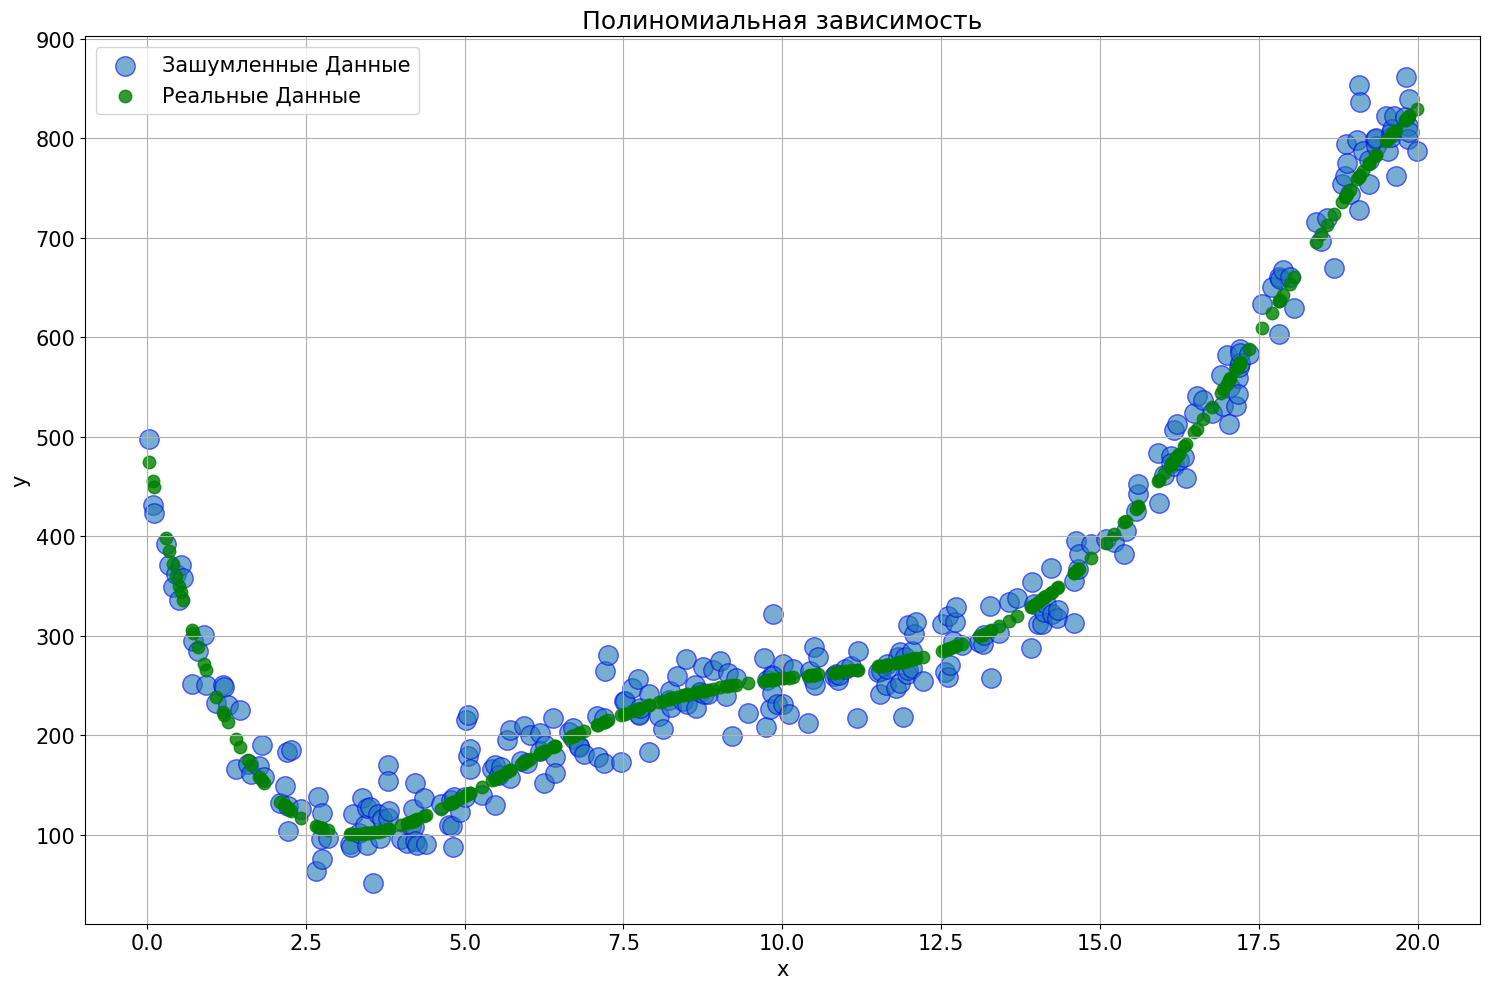

In [28]:
y2, y2_true, x2 = dataset(a = [-302.6, 82, -9.1, 00.45, -00.008 ],
                       b =483,
                       f = None,
                       x_count= 300,
                       x_max =20,
                       noise_power = 24,
                       seed = 100)
vis_data(y2, y2_true,x2, 'Полиномиальная зависимость')


## Генерация полигармонической зависимости (неустойчивая система)

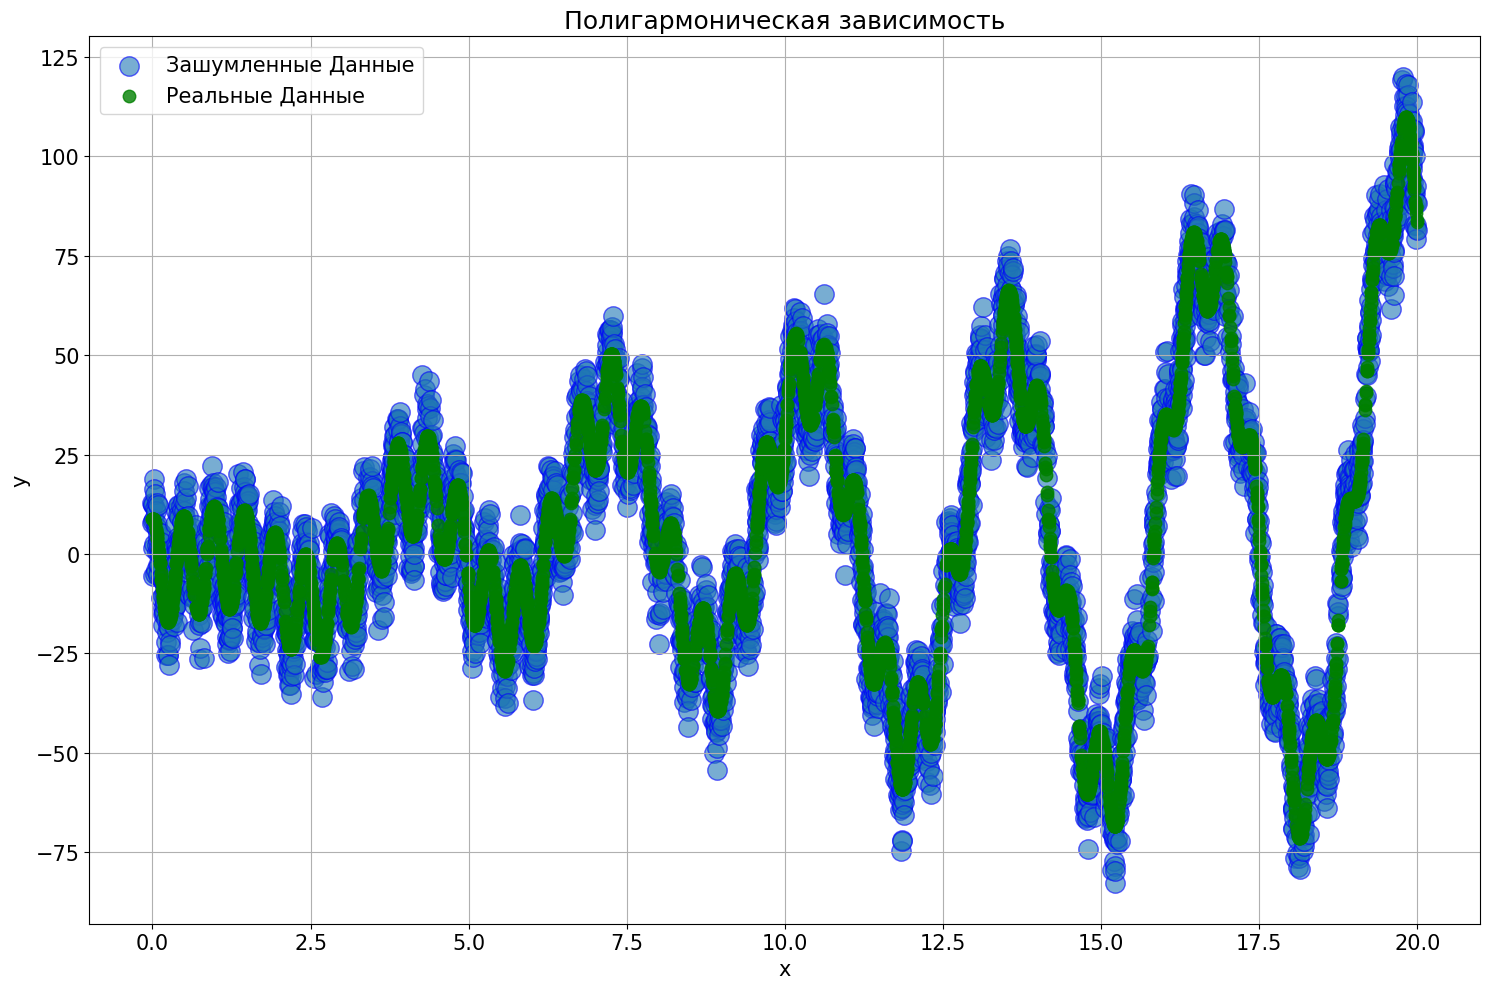

In [29]:
y3, y3_true, x3 = dataset(a = 0,
                       b =0,
                       f = [lambda x: 6*np.sin(x/2+23),
                           lambda x: 4*x*np.sin(x*2+6),
                            lambda x: 13*np.sin(x*13+1.5),
                            lambda x: np.exp(x/8)],
                       x_count= 4900,
                       x_max =20,
                       noise_power = 6,
                       seed = 100)
vis_data(y3, y3_true,x3, 'Полигармоническая зависимость')


# Полиномиальная регрессия

## Полиномиальная регрессия почти линейной зависимости (n=1)

Train Score = 0.98


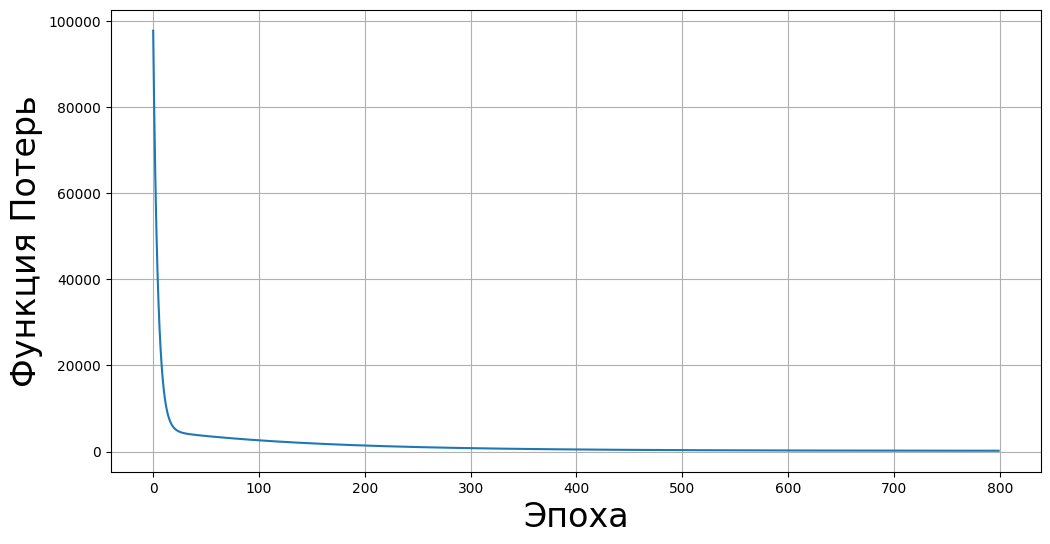

[36.87290061] 298.22290898550574


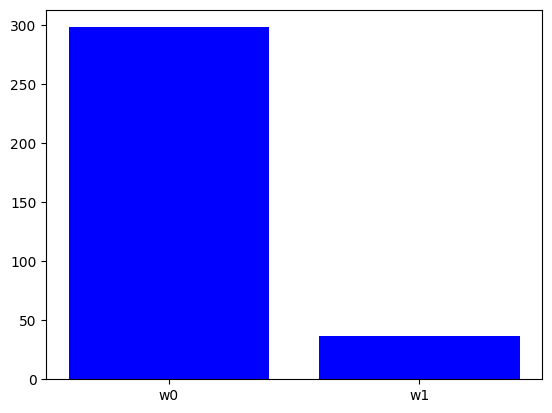

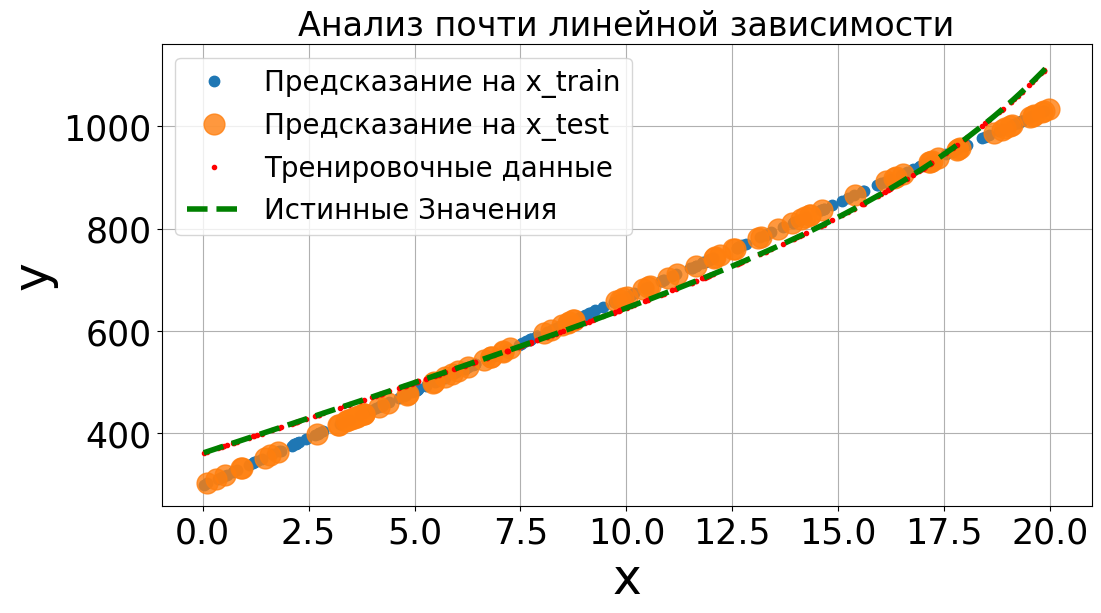

In [30]:
regr_poly_lin1_1 = LinearRegression(learning_rate=0.007,
                        epochs=800,  n_batches=5)

x_train1, x_test1, y_train1, y_test1 = regr_poly_lin1_1.train_test_split(x1, y1_true,  test_size=0.3)
regr_poly_lin1_1.fit(x_train1, y_train1)
print(f'Train Score = {regr_poly_lin1_1.score(x_train1, y_train1):.2f}')
regr_poly_lin1_1.plot_cost()
w, b = regr_poly_lin1_1.get_w_and_b()
print(w,b)

regr_poly_lin1_1.vis_weigths()
regr_poly_lin1_1.plot_model_class(x_train1, y_train1, x_test1, x1, y1_true, title='Анализ почти линейной зависимости')


Точность - 0.98. Линейная модель хорошо аппроксимирует данную зависимость. Функция потерь сходится быстро и хорошо. Дополнительные действия не требуются. Для проверки выполнена также регуляризация.

## Полиномиальная регрессия почти линейной зависимости (n=1) с регулязацией L2

Train Score = 0.98


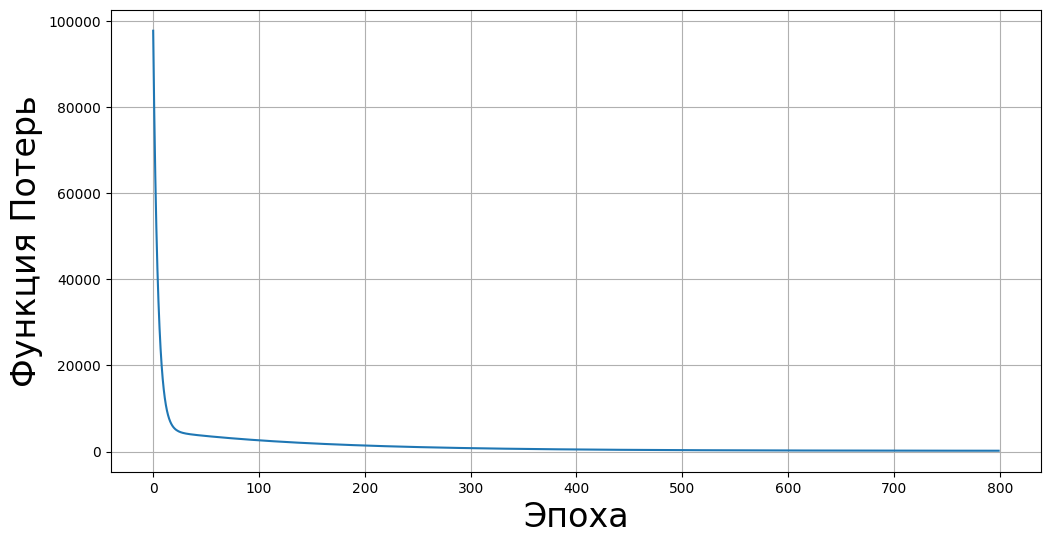

[36.8779854] 298.15312884204855


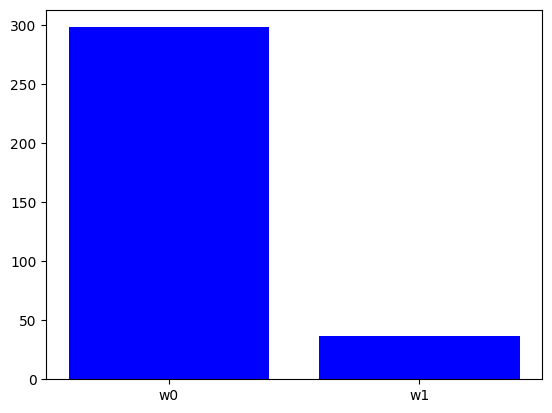

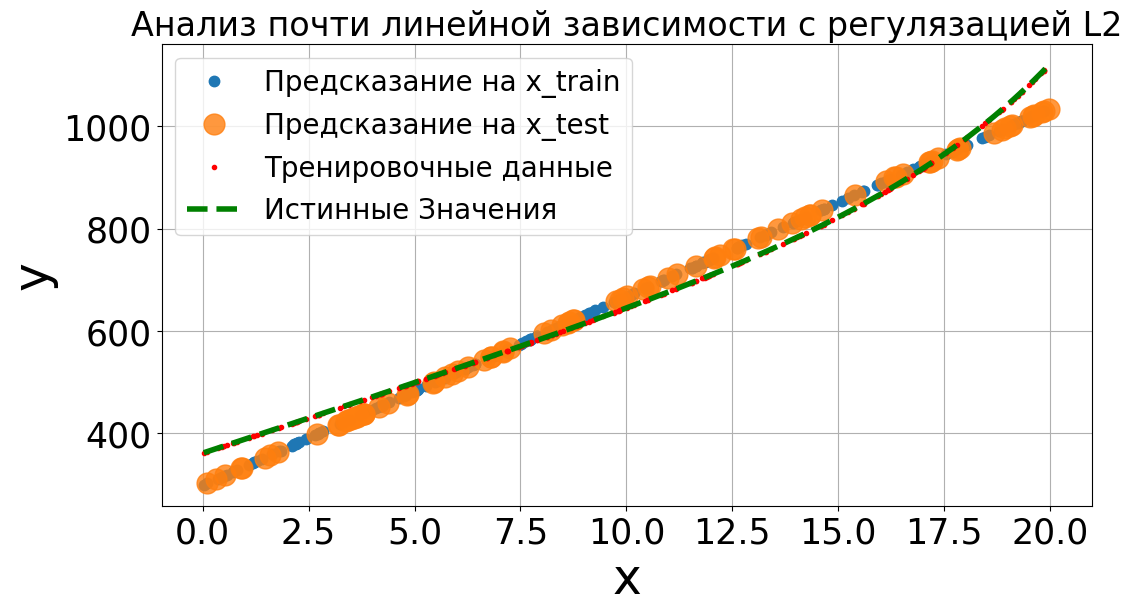

In [31]:
regr_poly_rid1_2 = RidgeRegression(learning_rate=0.007,
                        epochs=800,  n_batches=5, l2_penalty = 0.001)

regr_poly_rid1_2.fit(x_train1, y_train1)
print(f'Train Score = {regr_poly_rid1_2.score(x_train1, y_train1):.2f}')
regr_poly_rid1_2.plot_cost()
w, b = regr_poly_rid1_2.get_w_and_b()
print(w,b)

regr_poly_rid1_2.vis_weigths()
regr_poly_rid1_2.plot_model_class(x_train1, y_train1, x_test1, x1, y1_true, title='Анализ почти линейной зависимости с регулязацией L2')


Результат аналогичен предыдущему. Вывод - регуляризация не требуется.

## Полиномиальная регрессия полиномиальной зависимости (n=1)

Train Score = 0.68


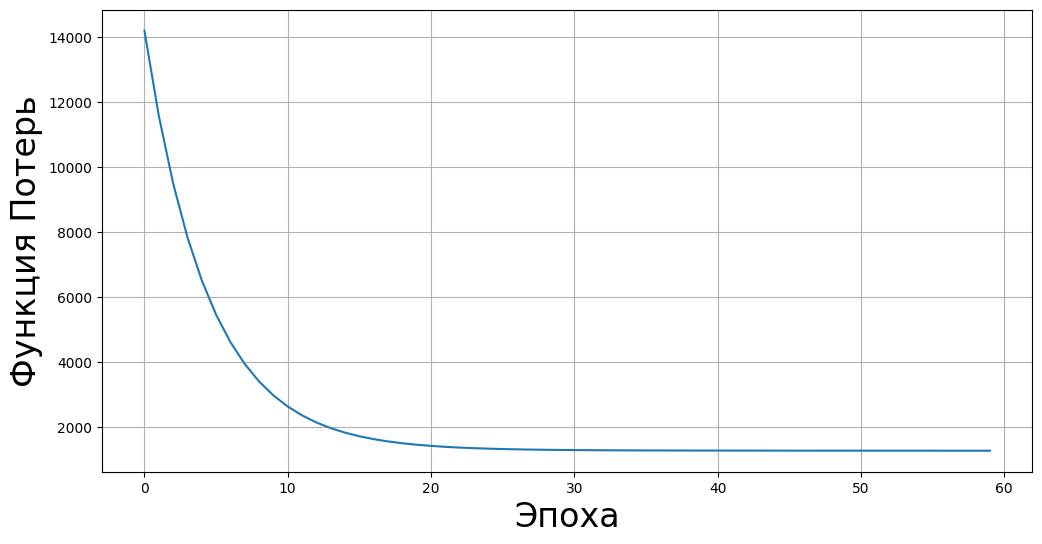

[30.7514871] 9.84066910655159


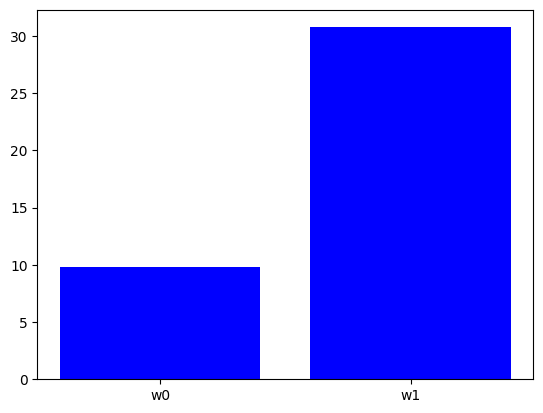

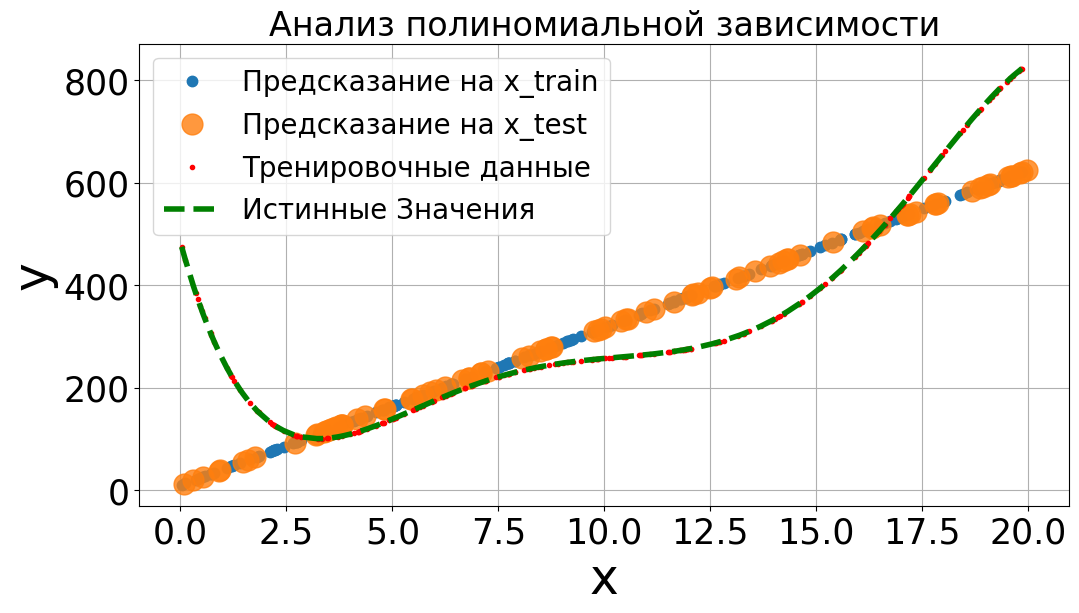

In [32]:
regr_poly_lin2_1 = LinearRegression(learning_rate=0.007,
                        epochs=60,  n_batches=10)

x_train2, x_test2, y_train2, y_test2 = regr_poly_lin2_1.train_test_split(x2, y2_true,  test_size=0.3)
regr_poly_lin2_1.fit(x_train2, y_train2)
print(f'Train Score = {regr_poly_lin2_1.score(x_train2, y_train2):.2f}')
regr_poly_lin2_1.plot_cost()
w, b = regr_poly_lin2_1.get_w_and_b()
print(w,b)

regr_poly_lin2_1.vis_weigths()
regr_poly_lin2_1.plot_model_class(x_train2, y_train2, x_test2, x2, y2_true, title='Анализ полиномиальной зависимости')


Вывод: точность аппроксимации низкая, функция потерь имеет тенденцию к снижению, но до нуля не доходит. Вывод - данная модель не подходит для этой зависимости.

## Полиномиальная регрессия полиномиальной зависимости (n=6)

Train Score = 0.99


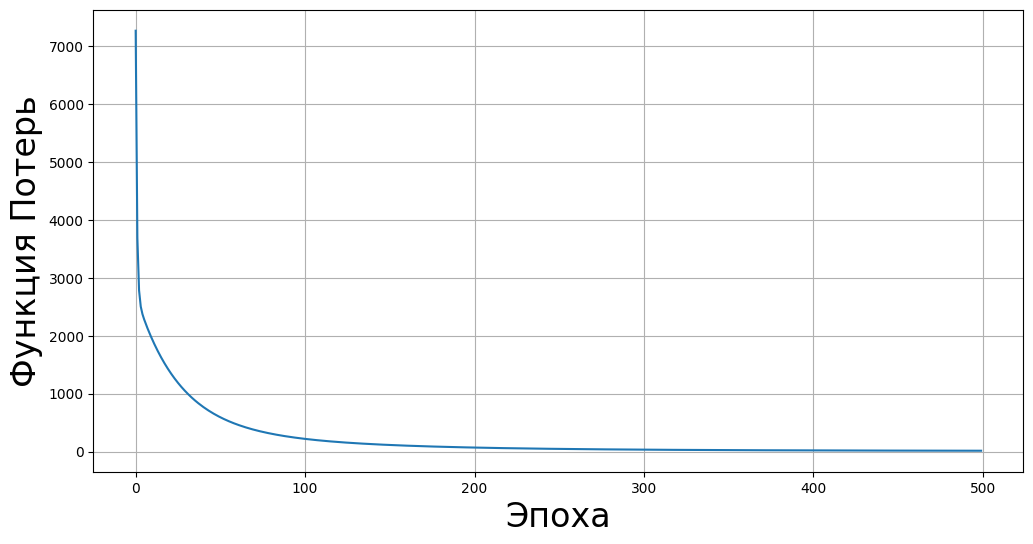

[ 99.99643548  38.74003992  93.40796479   8.71898213 -28.07455988
   7.9900897 ] 237.27673408462658


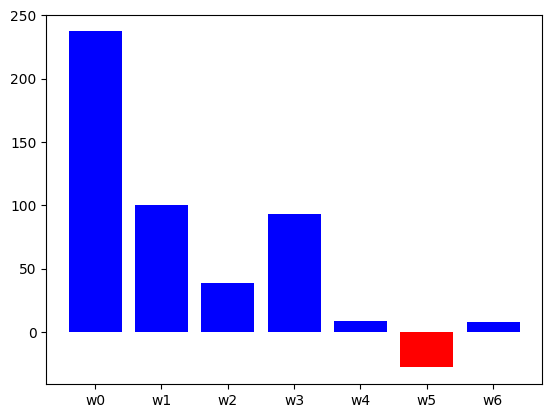

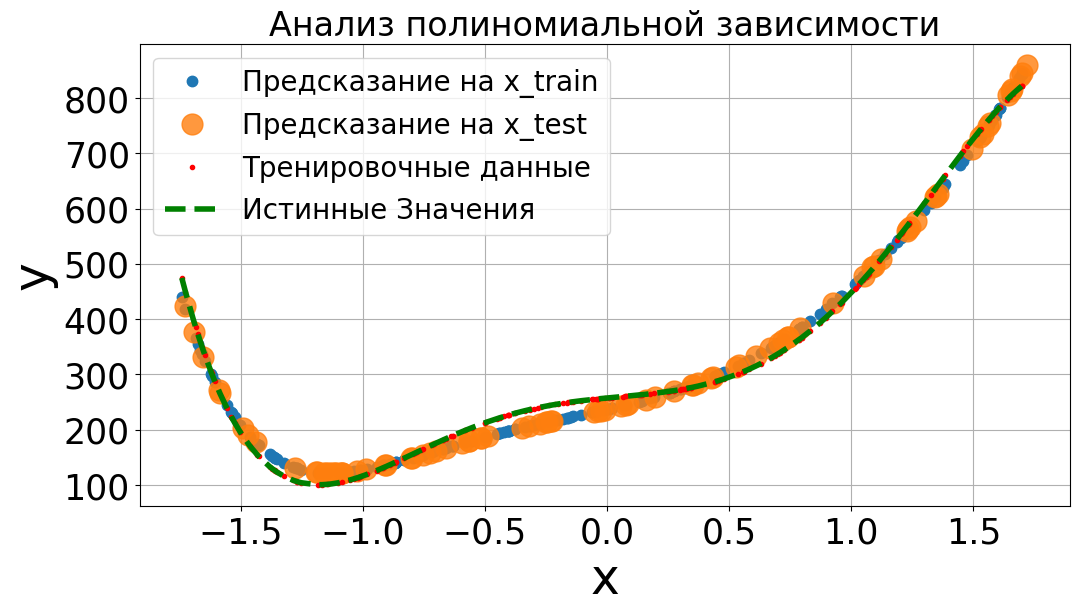

In [33]:
regr_poly_lin2_2 = LinearRegression(learning_rate=0.01,
                        epochs=500,  n_batches=20)

scaler = StandardScaler()
x_train_scaled2 = scaler.fit_transform(x_train2)
x_test_scaled2 = scaler.transform(x_test2)
x_scaled2 = scaler.transform(x2)

order  = 6
x_train2_ = regr_poly_lin2_2.to_polynom(x_train_scaled2, order=order)
x_test2_  = regr_poly_lin2_2.to_polynom(x_test_scaled2,  order=order)

regr_poly_lin2_2.fit(x_train2_, y_train2)
print(f'Train Score = {regr_poly_lin2_2.score(x_train2_, y_train2):.2f}')
regr_poly_lin2_2.plot_cost()
w, b = regr_poly_lin2_2.get_w_and_b()
print(w,b)

regr_poly_lin2_2.vis_weigths()
regr_poly_lin2_2.plot_model_class(x_train2_, y_train2, x_test2_, x_scaled2, y2_true, title='Анализ полиномиальной зависимости')


Модель имеет высокую точность (0,99), функция потерь хоть и не быстро, но сходится к 0.  Вывод: модель подходит для данной зависимости. Имеет смысл проверить, можно ли уменьшить число параметров. Для этого выполним регуляризацию.

## Полиномиальная регрессия полиномиальной зависимости (n=6) с регулязацией L1

Train Score = 0.93


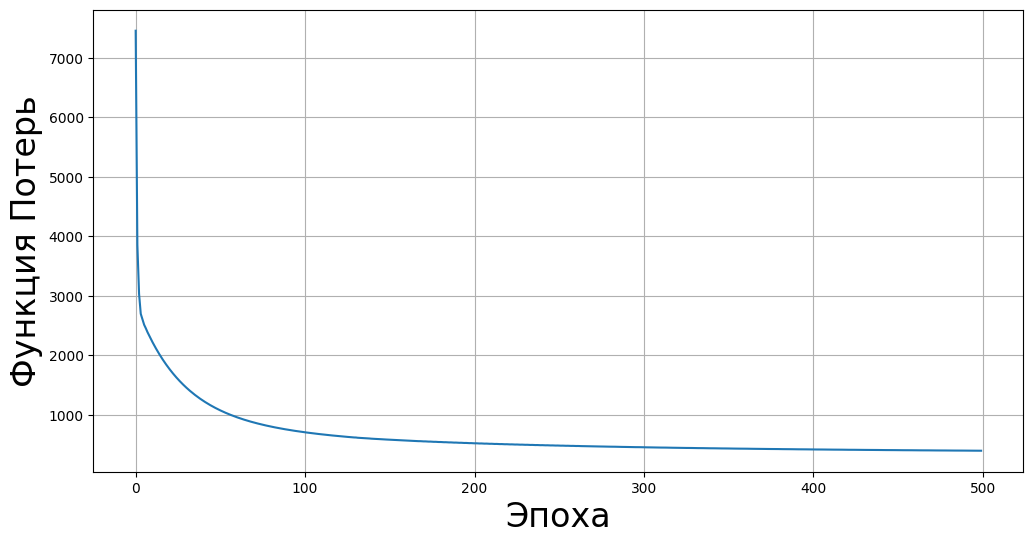

[6.88572097e+01 5.70668348e+00 3.66566152e+01 2.25493710e+00
 4.63292035e-02 1.59131889e+01] 228.032533443543


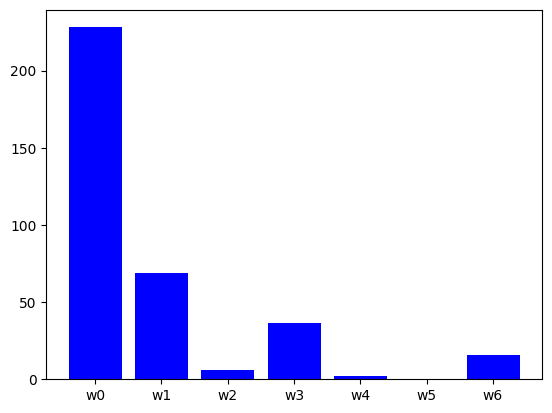

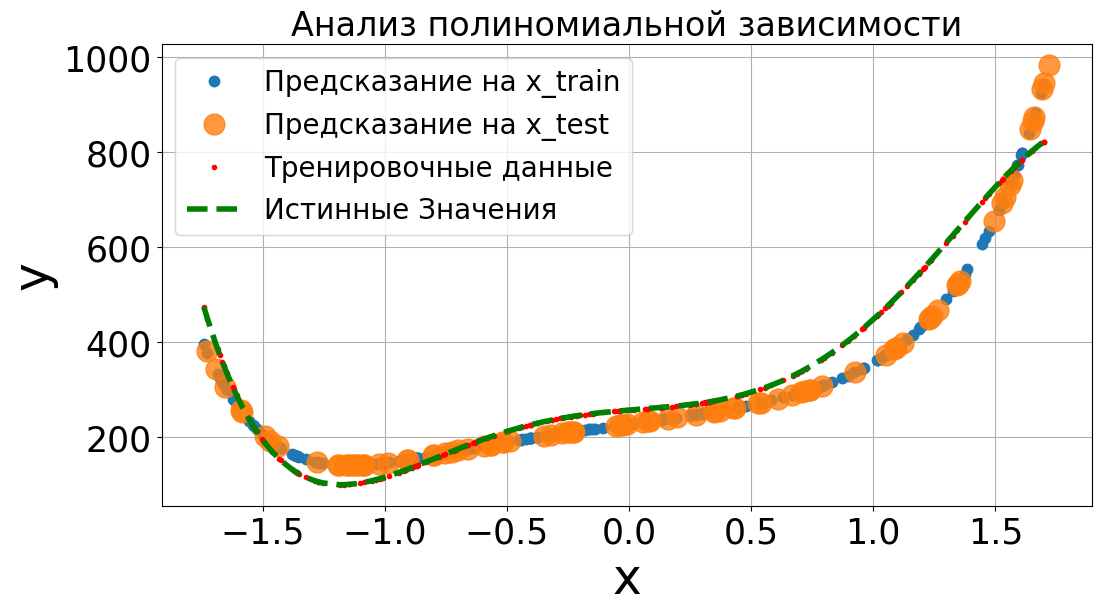

In [34]:
regr_poly_lin2_3 = LassoRegression(learning_rate=0.01, epochs=500,  n_batches=20, l1_penalty = 40)

regr_poly_lin2_3.fit(x_train2_, y_train2)
print(f'Train Score = {regr_poly_lin2_3.score(x_train2_, y_train2):.2f}')
regr_poly_lin2_3.plot_cost()
w, b = regr_poly_lin2_3.get_w_and_b()
print(w,b)

regr_poly_lin2_3.vis_weigths()
regr_poly_lin2_3.plot_model_class(x_train2_, y_train2, x_test2_, x_scaled2, y2_true, title='Анализ полиномиальной зависимости')


Анализ данных показывает, что параметры w4 и w5 можно отбросить. Точность модели при этом немного снизилась.

## Полиномиальная регрессия полиномиальной зависимости (n=6) с регулязацией L2

Train Score = 0.94


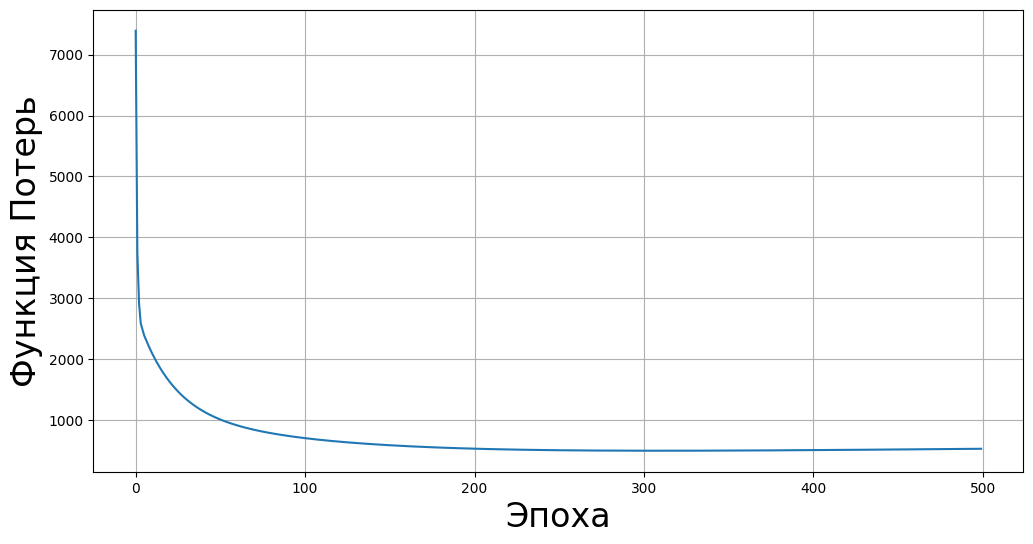

[ 55.66289925   0.20786647  68.65936894   2.91593701 -11.65335851
  16.48226378] 227.75333734004175


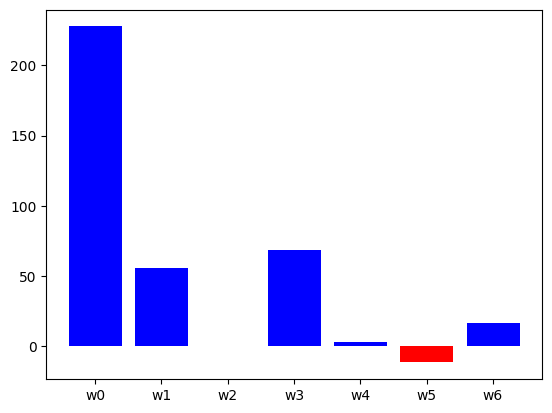

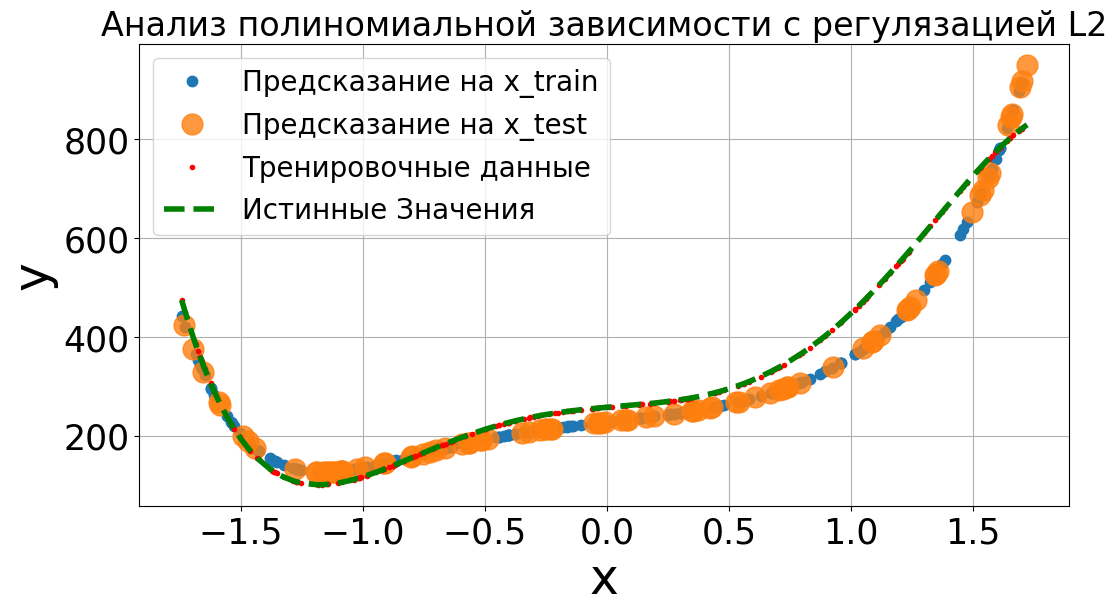

In [35]:
regr_poly_lin2_3 = RidgeRegression(learning_rate=0.01, epochs=500,  n_batches=20, l2_penalty = 2)
regr_poly_lin2_3.fit(x_train2_, y_train2)
print(f'Train Score = {regr_poly_lin2_3.score(x_train2_, y_train2):.2f}')
regr_poly_lin2_3.plot_cost()
w, b = regr_poly_lin2_3.get_w_and_b()
print(w,b)

regr_poly_lin2_3.vis_weigths()
regr_poly_lin2_3.plot_model_class(x_train2_, y_train2, x_test2_, x_scaled2, y2_true, title='Анализ полиномиальной зависимости с регулязацией L2')


Анализ данных показывает, что параметры w2 и w4 можно отбросить. Точность модели при этом немного снизилась.

## Полиномиальная регрессия полигармонической зависимости (n=1)

Train Score = 0.02


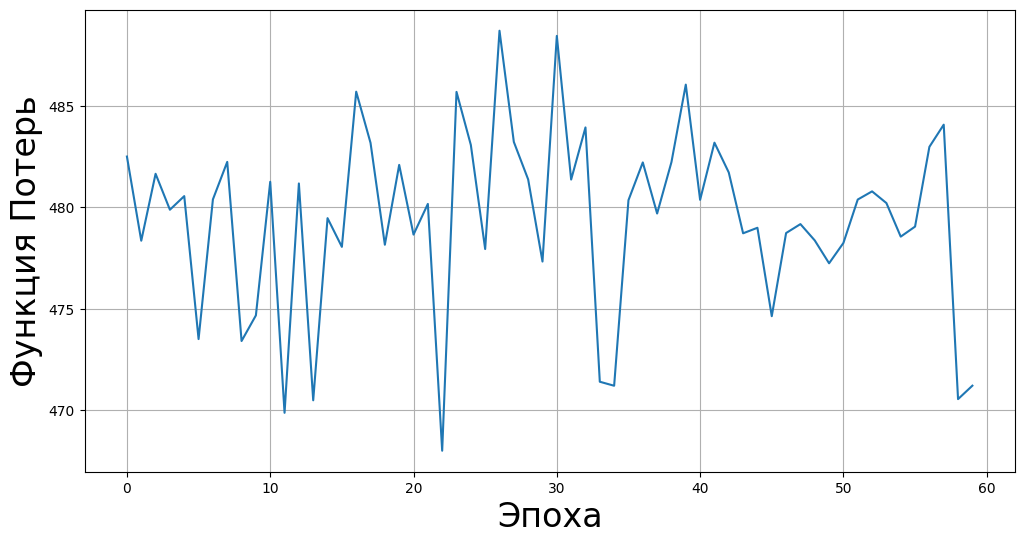

[0.65908797] -0.1357517027667842


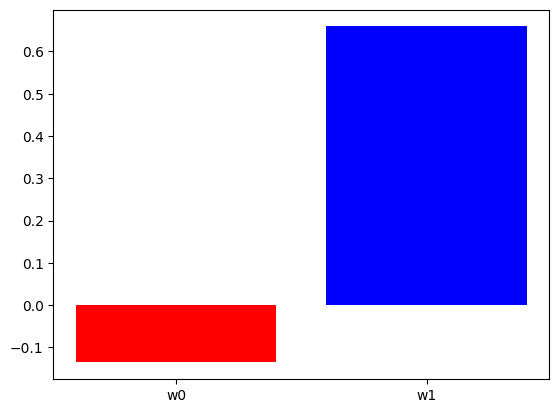

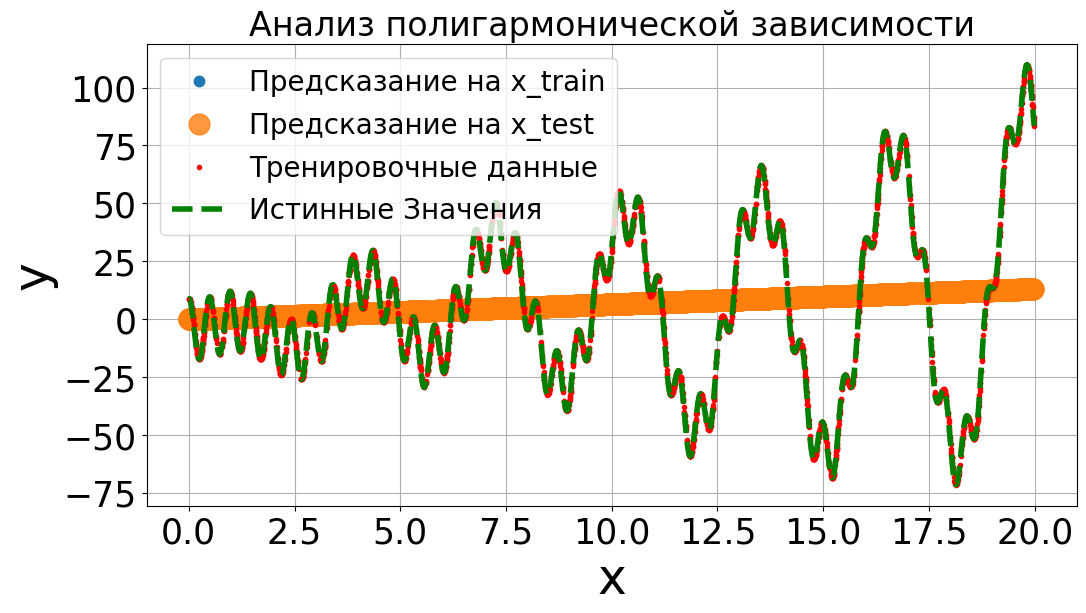

In [36]:
regr_poly_lin3_1 = LinearRegression(learning_rate=0.001,
                        epochs=60,  n_batches=10)

x_train3, x_test3, y_train3, y_test3 = regr_poly_lin3_1.train_test_split(x3, y3_true,  test_size=0.3)
regr_poly_lin3_1.fit(x_train3, y_train3)
print(f'Train Score = {regr_poly_lin3_1.score(x_train3, y_train3):.2f}')
regr_poly_lin3_1.plot_cost()
w, b = regr_poly_lin3_1.get_w_and_b()
print(w,b)

regr_poly_lin3_1.vis_weigths()
regr_poly_lin3_1.plot_model_class(x_train3, y_train3, x_test3, x3, y3_true, title='Анализ полигармонической зависимости')


Анализ графиков показывает, что модель абсолютно не подходит зависимости. Точность очень низкая, а функция потерь не имеет тенденции к стабилизации. Попробуем увеличить степень полинома.

## Полиномиальная регрессия полигармонической зависимости (n=16)

Train Score = 0.19


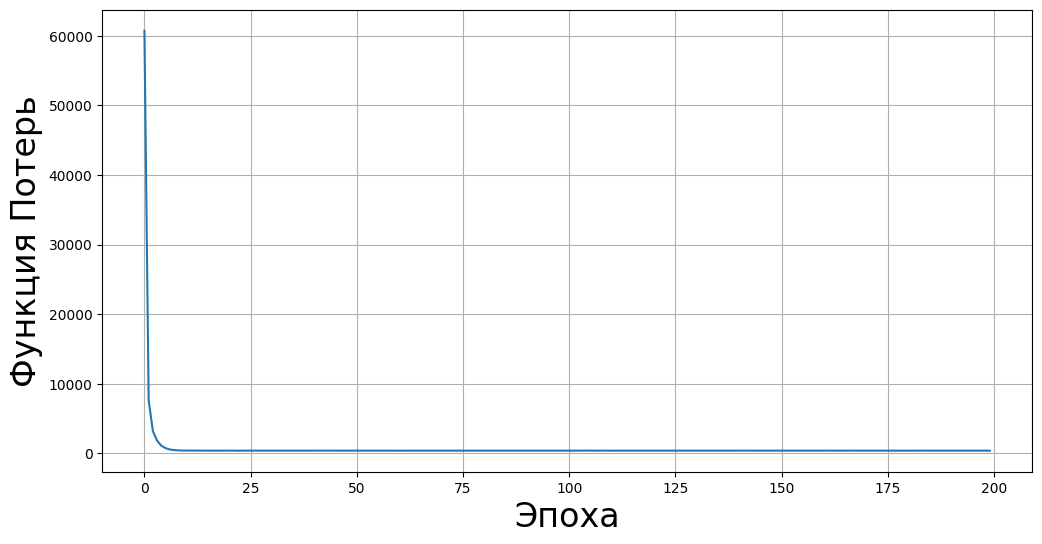

[ 0.12415659 -0.03404981  0.16218851  0.38174207 -0.05749291 -0.05629678
  0.39851421  0.19745748 -0.10482932  0.15037555 -0.07532639 -0.07693133
  0.18669087 -0.37241616 -0.04960178  0.14100261] 0.4972520852983416


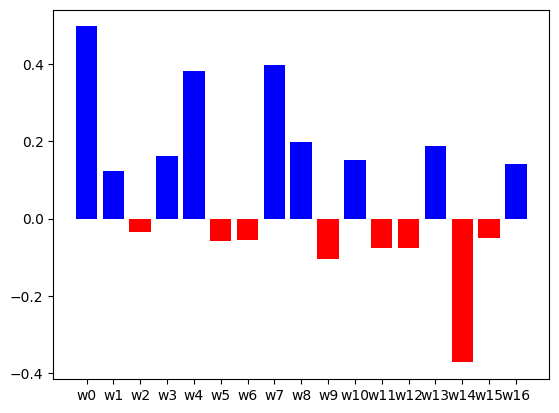

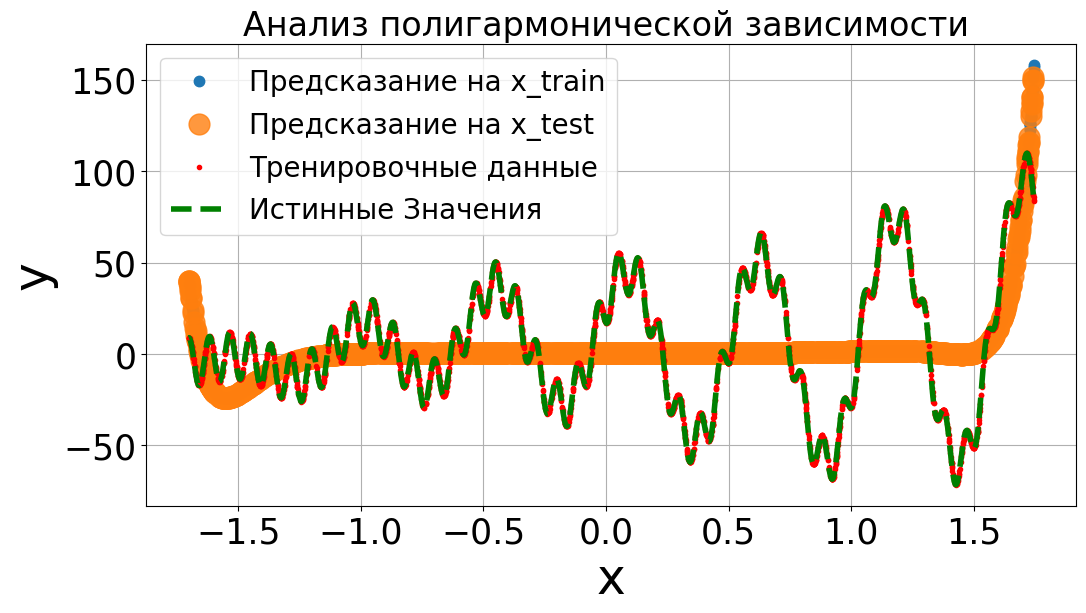

In [37]:
regr_poly_lin3_2 = LinearRegression(learning_rate=0.0000001,
                        epochs=200,  n_batches=10)

scaler = StandardScaler()
x_train_scaled3 = scaler.fit_transform(x_train3)
x_test_scaled3 = scaler.transform(x_test3)
x_scaled3 = scaler.transform(x3)

order  =16
x_train3_ = regr_poly_lin3_2.to_polynom(x_train_scaled3, order=order)
x_test3_  = regr_poly_lin3_2.to_polynom(x_test_scaled3,  order=order)

regr_poly_lin3_2.fit(x_train3_, y_train3)
print(f'Train Score = {regr_poly_lin3_2.score(x_train3_, y_train3):.2f}')
regr_poly_lin3_2.plot_cost()
w, b = regr_poly_lin3_2.get_w_and_b()
print(w,b)

regr_poly_lin3_2.vis_weigths()
regr_poly_lin3_2.plot_model_class(x_train3_, y_train3, x_test3_, x_scaled3, y3_true, title='Анализ полигармонической зависимости ')


Точность модели чуть выше, чем в предыдущем случае. Функция потерь сходится к некоторому ненулевому значению. Однако данная модель также абсолютно не подходит к данной зависмости. Возможно нужна более высокая степень полинома, однако вычислить такую модель проблематично из-за ошибки переполнения. Стандартизация исходных данных позволила лишь немного сдвинуть границу применимости этого метода. Ну и для интереса выполнена регуляризация.

## Полиномиальная регрессия полиномиальной зависимости (n=16) с регулязацией L2

Train Score = 0.19


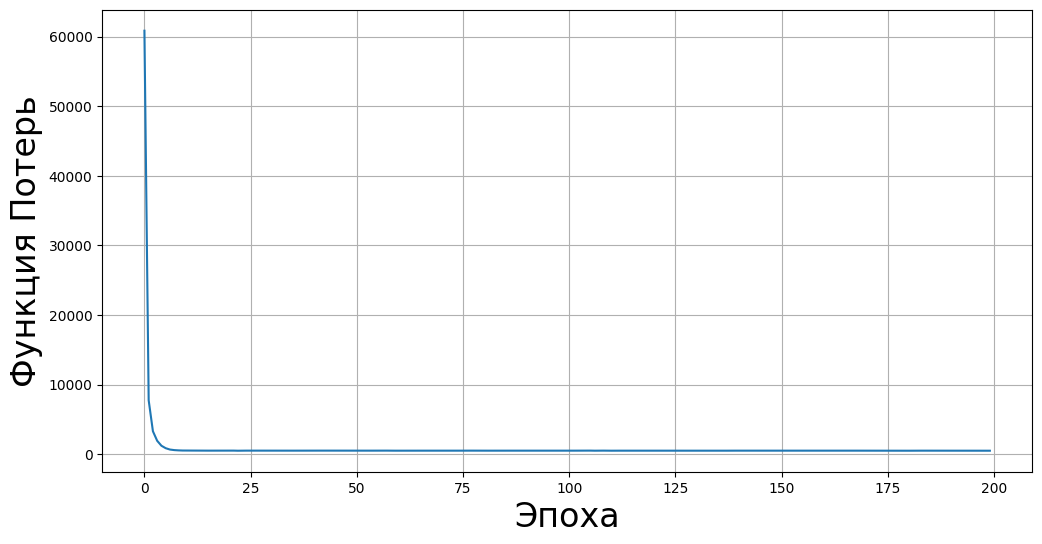

[ 0.11615105 -0.02605938  0.15417336  0.37372424 -0.04953348 -0.0483272
  0.39040622  0.18941532 -0.0971161   0.14235476 -0.06808674 -0.06876436
  0.17667812 -0.36341449 -0.04691958  0.1371448 ] 0.48924736136836616


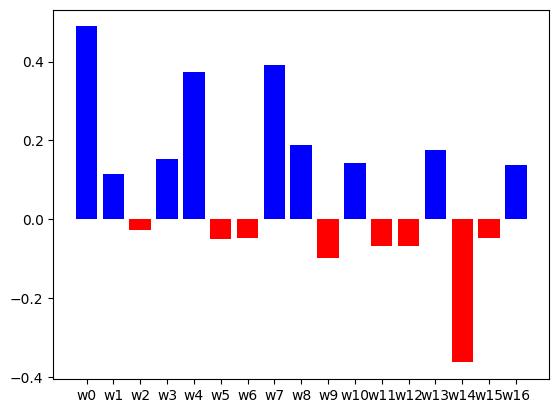

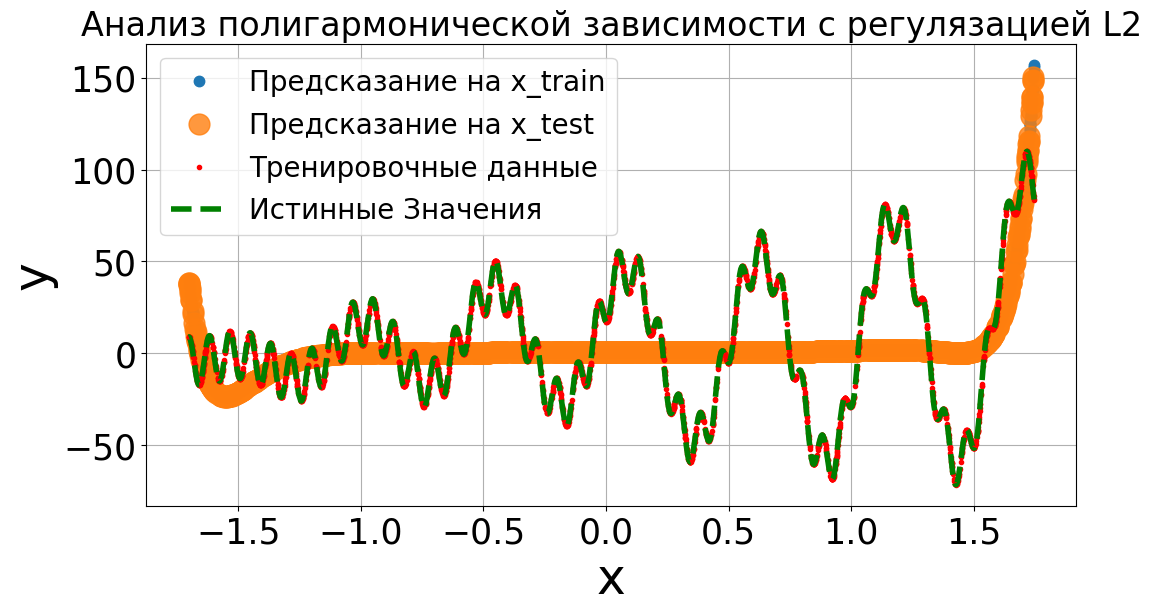

In [38]:
regr_poly_lin3_2 = LassoRegression(learning_rate=0.0000001, epochs=200,  n_batches=10, l1_penalty =100)

scaler = StandardScaler()
x_train_scaled3 = scaler.fit_transform(x_train3)
x_test_scaled3 = scaler.transform(x_test3)
x_scaled3 = scaler.transform(x3)

order  =16
x_train3_ = regr_poly_lin3_2.to_polynom(x_train_scaled3, order=order)
x_test3_  = regr_poly_lin3_2.to_polynom(x_test_scaled3,  order=order)

regr_poly_lin3_2.fit(x_train3_, y_train3)
print(f'Train Score = {regr_poly_lin3_2.score(x_train3_, y_train3):.2f}')
regr_poly_lin3_2.plot_cost()
w, b = regr_poly_lin3_2.get_w_and_b()
print(w,b)

regr_poly_lin3_2.vis_weigths()
regr_poly_lin3_2.plot_model_class(x_train3_, y_train3, x_test3_, x_scaled3, y3_true, title='Анализ полигармонической зависимости с регулязацией L2')


Никакой пользы от регуляризации в данном случае также нет.
